In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier as KNN

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Ob_set is the Obesity set of date. It has the obesity rates from 2004 - 2012 per county
#Lets load in the data toutilize it further
#"number yyyy" is the percentage of obese idividuals based on the surverys done each year for the entire county
Obset = pd.read_excel("OB_PREV_ALL_STATES.xlsx", "obesity")
#Remove all the extra data in the Obesity list to leave just the numbers and % obese per county
for col in Obset.columns[3:]:
    if 'number' not in col and 'percent' not in col or 'age' in col:
        del Obset[col]

for col in Obset.columns[3:]:
    if '2009' not in col and '2012' not in col and '2010' not in col:
        del Obset[col]
        
#delete any NaN values for a better data set
Obset = Obset.dropna(how='any')

#Sort the set by FIPS nuber
Obset = Obset.sort(columns='FIPS Codes', axis=0)

In [3]:
#Food Access Data
FoodAccess = pd.read_excel("FoodSecAllup.xls", 'ACCESS')
#Food Security
Restaurants = pd.read_excel("FoodSecAllup.xls", 'RESTAURANTS')
#Food Stores Density
Stores = pd.read_excel("FoodSecAllup.xls", 'STORES')
#Farmers Market Data
FarmMkt = pd.read_csv("Farmers_market_Dir.csv")
#Food Assistance Data
Assistance = pd.read_excel("FoodSecAllup.xls", "ASSISTANCE")
#Food Inseciruty Data
Insecurity = pd.read_excel("FoodSecAllup.xls", "INSECURITY")
#Food Local Data
Local = pd.read_excel("FoodSecAllup.xls", "LOCAL")
#Food Prices and Taxes
FPrices = pd.read_excel("FoodSecAllup.xls", "PRICES_TAXES")
#Socioeconomic factors 
SociEcon = pd.read_excel("FoodSecAllup.xls", "SOCIOECONOMIC")

#### Famers Markets
This code finds how many farmers markets there are per county and then merges them to the Obesity data set on a County/State key that is necessary as the Farmers Markets data does not have the FIPS code which would designate which county the market is in.

In [4]:
#Drop (remove) the columns in the farmers market data set that we dont need
#remove all coumns but 9 & 10
FarmMkt = FarmMkt.drop(FarmMkt.columns[1:8], axis=1)#,inplace=True)
FarmMkt = FarmMkt.drop(FarmMkt.columns[4:], axis=1)
FarmMkt = FarmMkt.dropna(subset=['County'], how='all') #drop all rows that have any NaN values

#make a new column in FarmMkt and Obset to be a key to match the county/state pair
Obset['CSKey'] = Obset[['County','State']].sum(axis=1)
FarmMkt['CSKey'] = FarmMkt[['County','State']].sum(axis=1)

#New frame for the group by for the farmers market data
NewFrame = FarmMkt.groupby('CSKey').count()
NewFrame = NewFrame.drop(NewFrame.columns[1:], axis=1)
NewFrame.columns = ['FarmersMkts Per County']
#then merge it with the OBesity set to have the Fearmers market counts
#Obset['FarmersMkts Per County'] = Obset.merge(NewFrame, on=NewFrame.index, how='left')
Obset = pd.merge(Obset, NewFrame, how='left', left_on='CSKey',left_index=False, right_index=True, sort=True, copy=True)
#then drop the Key from the Obset data as no longer needed
Obset = Obset.drop(Obset.columns[Obset.columns.get_loc('CSKey')], axis=1)
#Change all the Nan values in the Famers count to 0
Obset['FarmersMkts Per County'] = Obset['FarmersMkts Per County'].fillna(int(0))
#Change all the Farmers market vals to ints
Obset['FarmersMkts Per County'] = Obset['FarmersMkts Per County'].astype(int)

#### Low Access to Grocery Stores
This code combines the Grocery store access data with the obesity set. 

3 Data Sets: 
1. Population's with low access to grocery stores
2. Population with Low income access to grocery stores
3. Population with no car and low income access to grocery stores

In [5]:
#Remove the FoodAcces columns we wont use:
for col in FoodAccess.columns[3:]:
    if 'PCT' not in col:
        del FoodAccess[col]

FoodAccess = FoodAccess.drop('PCT_LACCESS_CHILD10', axis=1)
FoodAccess = FoodAccess.drop('PCT_LACCESS_SENIORS10', axis=1)

In [6]:
#Merge the Access data to the Obset
Obset = pd.merge(Obset, FoodAccess.ix[:,3:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Grocery Stores and SuperCenters

4 Data Sets: 
1. Grocery Stores per 1000 people
2. Supercenters per 1000 people
3. Convenience Stores per 1000 people
4. SNAP accepting Stores per 1000 people

In [7]:
#Remove the FoodAcces columns we wont use:
for col in Stores.columns[3:]:
    if 'PTH12' not in col:
        del Stores[col]

Stores = Stores.drop('SPECSPTH12', axis=1)
Stores = Stores.drop('WICSPTH12', axis=1)

In [8]:
#Merge Restaurants
Obset = pd.merge(Obset, Stores.ix[:,3:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Restaurants
This code combines the Restaurant data with the obesity set. I will use the expenditure change from 02-07 to estimate the amount for 2012. 

4 Data Sets: 
1. Fast Food restaurants per 1000 people (2012)
2. Restaurants per 1000 people (2012)
3. Fast Food Restaurant Expenditures per capita (2012 estimate)
4. Restaurant Expenditures per capita (2012 estimate)

Estiamte Expenditures per capita: (2007/2002)*2007

In [9]:
#Remove the FoodAcces columns we wont use:
for col in Restaurants.columns[3:]:
    if 'PTH12' not in col and 'PC_F' not in col:
        del Restaurants[col]

In [10]:
#Find the change in expenditures and use this to estimate 2012
Restaurants['PC_FFRSALES12'] = ( Restaurants['PC_FFRSALES07'] / Restaurants['PC_FFRSALES02'] ) * Restaurants['PC_FFRSALES07']
Restaurants['PC_FSRSALES12'] = ( Restaurants['PC_FSRSALES07'] / Restaurants['PC_FSRSALES02'] ) * Restaurants['PC_FSRSALES07']

In [11]:
#Remove the now unneeded expenditure columns
Restaurants = Restaurants.drop('PC_FFRSALES02', axis=1)
Restaurants = Restaurants.drop('PC_FFRSALES07', axis=1)
Restaurants = Restaurants.drop('PC_FSRSALES02', axis=1)
Restaurants = Restaurants.drop('PC_FSRSALES07', axis=1)

In [12]:
#Merge Restaurants
Obset = pd.merge(Obset, Restaurants.ix[:,3:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Low Income Food Assistance

8 Data Sets: 
1. SNAP redemptions/SNAP-authorized stores, 2012
2. SNAP participants (% pop), 2009
3. SNAP benefits per capita, 2010
4. SNAP participants (% eligible pop), 2010*
5. National School Lunch Program participants (% pop), 2009
6. Students eligible for free lunch (%), 2010
7. Students eligible for reduced-price lunch (%), 2010
8. SchoolSchool Breakfast Program participants (% pop), 2009

In [13]:
Keep = ['FIPS','REDEMP_SNAPS12','PCT_SNAP09','PC_SNAPBEN10',
 'SNAP_PART_RATE10','PCT_NSLP09','PCT_FREE_LUNCH10','PCT_REDUCED_LUNCH10','PCT_SBP09']
Assistance2 = Assistance[Keep]

In [14]:
#Merge Assistance2
Obset = pd.merge(Obset, Assistance2.ix[:,1:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Food Insecurity

2 Data Sets: 
1. Household food insecurity (%, three-year average), 2010-12
2. Household very low food security (%, three-year average), 2010-12

In [15]:
Keep = ['FIPS','FOODINSEC_10_12','VLFOODSEC_10_12']
Insecurity2 = Insecurity[Keep]

In [16]:
#Merge Assistance2
Obset = pd.merge(Obset, Insecurity2.ix[:,1:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Local food Factors

2 Data Sets: 
1. Farmers' markets, 2013

In [17]:
Keep = ['FIPS', 'FMRKT13']
Local2 = Local[Keep]

In [18]:
#Merge Assistance2
Obset2 = pd.merge(Obset, Local2.ix[:,1:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

In [19]:
Obset2['FDiff'] = Obset2['FarmersMkts Per County'] - Obset2['FMRKT13']

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Multivariable Regression

Here I will use the sklearn linear_model to see if there is any relationship between the many variables that I have loaded into the Obset

Column Name| Description
-|-
FarmersMkts Per County| Farmers Markets Per County  
PCT_LACCESS_POP10| Percent of the popultion who have access to grocery stores  
PCT_LACCESS_LOWI10| Low Income Percent of the popultion who have access to grocery stores  
PCT_LACCESS_HHNV10| Low Income Percent of the popultion who have access to grocery stores without a car  
GROCPTH12| Grocery stores per 1000 people  
SUPERCPTH12| Supercenters per 1000 people  
CONVSPTH12| Convenience Stores per 1000 people  
SNAPSPTH12| SNAP-authorized stores per 1,000 people  
FFRPTH12| Fast-food restaurants per 1,000 people  
FSRPTH12| Full-service restaurants per 1,000 people  
PC_FFRSALES12| Expenditures per capita, fast food  
PC_FSRSALES12| Expenditures per capita, full service restaurant  
REDEMP_SNAPS12| SNAP redemptions/SNAP-authorized stores  
PCT_SNAP09| SNAP participants (% pop)  
PC_SNAPBEN10| SNAP benefits per capita  
SNAP_PART_RATE10| SNAP participants (% eligible pop)  
PCT_NSLP09| National School Lunch Program participants (% pop)  
PCT_FREE_LUNCH10| Students eligible for free lunch (%)  
PCT_REDUCED_LUNCH10| Students eligible for reduced-price lunch (%)  
PCT_SBP09| School Breakfast Program participants (% pop)  
FOODINSEC_10_12| Household food insecurity (%, three-year average)  
VLFOODSEC_10_12| Household very low food security (%, three-year average)


In [21]:
from sklearn import linear_model
from sklearn import cross_validation

ObsetRun = Obset.dropna(how='any')

In [22]:
ColNames = ['FarmersMkts Per County', 'PCT_LACCESS_POP10','PCT_LACCESS_LOWI10', 'PCT_LACCESS_HHNV10', 'GROCPTH12',
       'SUPERCPTH12', 'CONVSPTH12', 'SNAPSPTH12', 'FFRPTH12','FSRPTH12', 'PC_FFRSALES12', 'PC_FSRSALES12', 'REDEMP_SNAPS12',
       'PCT_SNAP09', 'PC_SNAPBEN10', 'SNAP_PART_RATE10', 'PCT_NSLP09','PCT_FREE_LUNCH10', 'PCT_REDUCED_LUNCH10', 'PCT_SBP09',
       'FOODINSEC_10_12', 'VLFOODSEC_10_12']

FoodAccess = ['FarmersMkts Per County', 'PCT_LACCESS_POP10','PCT_LACCESS_LOWI10', 'PCT_LACCESS_HHNV10', 'GROCPTH12',
              'SUPERCPTH12', 'CONVSPTH12','FFRPTH12','FSRPTH12']

SocioEcon = ['SNAPSPTH12','REDEMP_SNAPS12','PCT_SNAP09', 'PC_SNAPBEN10', 'SNAP_PART_RATE10', 'PCT_NSLP09','PCT_FREE_LUNCH10', 
             'PCT_REDUCED_LUNCH10', 'PCT_SBP09','FOODINSEC_10_12', 'VLFOODSEC_10_12']

SNAP = ['SNAPSPTH12','REDEMP_SNAPS12','PCT_SNAP09', 'PC_SNAPBEN10', 'SNAP_PART_RATE10']

PopAct = ['PC_FFRSALES12', 'PC_FSRSALES12']

In [89]:
ObsetRun = Obset.dropna(how='any')

#ColNames
#FoodAccess
#SocioEcon
#SNAP 
#PopAct

Cols = PopAct

X = ObsetRun[Cols]
maxRF = len(Cols)
y = ObsetRun['percent 2012']
#y = ObsetRun['cut5']

In [90]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y,train_size=.9)

X = x_train
y = y_train

#Create linear regression object
linear = linear_model.LinearRegression()

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)

#Equation coefficient and Intercept
print 'Linear Val Scores: \n', Lin_vals
print
print 'Mean Linear Val Score: ', np.mean(Lin_vals)
print 'Test Linear Val Score: ',linear.score(x_test, y_test)

Linear Val Scores: 
[ 0.07230618  0.09504269  0.13172711 -0.03905771  0.04250574  0.19945669
  0.09961124  0.10930812  0.13331121  0.0528285 ]

Mean Linear Val Score:  0.0897039786785
Test Linear Val Score:  0.0679072992985


#### KNN

In [91]:
y = np.array(y).astype(int)
y_test = np.array(y_test).astype(int)

In [92]:
# Let's test various values of K
n_neighbors = range(1,51,2)

scores = []
for n in n_neighbors:
    model = KNN(n)
    model.fit(X, y)
    scores.append(model.score(x_test, y_test))

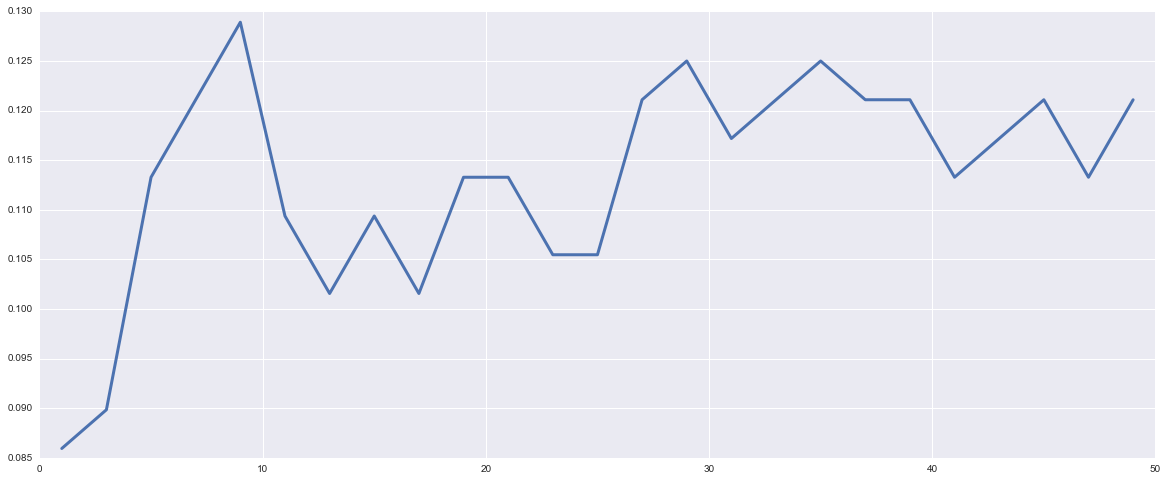

In [93]:
plt.figure(figsize=(20,8))
plt.plot(n_neighbors, scores, linewidth=3.0)
plt.show()

In [94]:
from sklearn import cross_validation

K_hold = {}
count_n = 0
count_f = 0
for n in n_neighbors:
    model = KNN(n)
    count_n += 1
    n_scores = cross_validation.cross_val_score(model, X, y, cv=10) #, scoring='mean_squared_error')
    K_hold[count_n] = "Accuracy: %.3f (+/- %.3f)" % (n_scores.mean(), n_scores.std() * 2)
    count_f += 1

In [95]:
print("Accuracy: %.3f (+/- %0.3f)" % (n_scores.mean(), n_scores.std() * 2))

Accuracy: 0.120 (+/- 0.037)


In [30]:
print K_hold

{1: 'Accuracy: 0.07 (+/- 0.04)', 2: 'Accuracy: 0.08 (+/- 0.03)', 3: 'Accuracy: 0.07 (+/- 0.04)', 4: 'Accuracy: 0.08 (+/- 0.04)', 5: 'Accuracy: 0.08 (+/- 0.03)', 6: 'Accuracy: 0.08 (+/- 0.03)', 7: 'Accuracy: 0.08 (+/- 0.03)', 8: 'Accuracy: 0.08 (+/- 0.02)', 9: 'Accuracy: 0.08 (+/- 0.02)', 10: 'Accuracy: 0.07 (+/- 0.02)', 11: 'Accuracy: 0.08 (+/- 0.03)', 12: 'Accuracy: 0.09 (+/- 0.04)', 13: 'Accuracy: 0.09 (+/- 0.04)', 14: 'Accuracy: 0.09 (+/- 0.03)', 15: 'Accuracy: 0.08 (+/- 0.03)', 16: 'Accuracy: 0.09 (+/- 0.03)', 17: 'Accuracy: 0.09 (+/- 0.03)', 18: 'Accuracy: 0.09 (+/- 0.03)', 19: 'Accuracy: 0.10 (+/- 0.02)', 20: 'Accuracy: 0.10 (+/- 0.02)', 21: 'Accuracy: 0.10 (+/- 0.03)', 22: 'Accuracy: 0.10 (+/- 0.02)', 23: 'Accuracy: 0.10 (+/- 0.02)', 24: 'Accuracy: 0.10 (+/- 0.03)', 25: 'Accuracy: 0.10 (+/- 0.04)'}


In [35]:
from sklearn import feature_selection
F = feature_selection.f_classif(X, y)[0]
title = 'FF Features with F-Values'

plt.figure(figsize=(13, 8))
ax = sns.barplot(x=Obset.columns[:-1],y=F)
ax.set_title(title)
ax.set(xlabel="Features");

AssertionError: Grouper and axis must be same length

In [63]:
from sklearn.ensemble import RandomForestClassifier
maxRF = len(Cols)

forest = RandomForestClassifier(n_estimators=500,
     max_features=int(maxRF), random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y,cv=10)
print "RandomForestClassifier %i: %.3f" % (int(maxRF),scores.mean())
forest.fit(X, y)
cm = confusion_matrix(y_test, forest.predict(x_test))

RandomForestClassifier 2: 0.108


In [64]:
def plot_confusion_matrix(cm, title='Random Forest Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

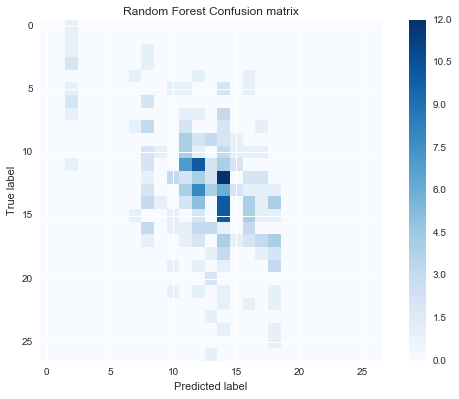

In [65]:
plot_confusion_matrix(cm)

#### Random Forests of Continuous Data

In [ ]:
y = np.array(y).astype(int)
y_test = np.array(y_test).astype(int)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
maxRF = len(Cols)

forest = RandomForestClassifier(n_estimators=500,
     max_features=int(maxRF), random_state=0, max_depth=None)

scores = cross_validation.cross_val_score(forest, X.values, y.values,cv=10)

print "RandomForestClassifier %i: %.3f" % int(maxRF,scores.mean())
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

##### Conclusion: Poor fit
The coefficients of the line vary too much to get a meaningful model.
###### Next Step: Group the Variables by type and make multiple multivariable linear regression lines:

Look up:
Feature importance
Feature weight


# Logisitic Regression
Classify the Obesity Rate to Apply  
Since the Obesity rate has a large variance our modeling is not good at predicting it accurately so here I will categorize the Obesity rate into 2 classes: Acceptable and Unnaceptable. 

This categorization will be determined by the median value of the percentage of Obesity per county. If the county is below the median, it will be classified with a 0 and 1 otherwise. 

In [ ]:
obmedian = np.median(Obset['percent 2012'])
print obmedian

def medd(percent):
    if percent > obmedian:
        return 1
    else:
        return 0

In [ ]:
Obset['median12'] = Obset['percent 2012'].apply(medd)

##### Above we did Binary Logistic Regression, so lets try 5-part LR
These will treated as dummies and we will do the regression off of these

In [ ]:
def cut5(percent):
    if percent <= 17.88:
        return 0
    elif percent <= 25.06:
        return 1
    elif percent <= 32.24:
        return 2
    elif percent <= 39.42:
        return 3
    else: 
        return 4

In [ ]:
Obset['cut5'] = Obset['percent 2012'].apply(cut5)

-----

#### All 22 FDA Factors:
This is the Multivariable Linear Regression modelling for all 22 Food Factor Variables. 

In [ ]:
ObsetRun = Obset.dropna(how='any')

#ColNames
#FoodAccess
#SocioEcon
#SNAP 
#PopAct

Cols = FoodAccess

X = ObsetRun[Cols]
maxRF = len(Cols)
y = ObsetRun['median12']
#y = ObsetRun['cut5']

In [ ]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y,train_size=.9)

X = x_train
y = y_train

# Create linear regression object
linear = linear_model.LinearRegression()

#Another model: bagging decision trees
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Another model: boosting decision trees
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)
Bag_vals = cross_validation.cross_val_score(bagging, X.values, y.values, cv=10)
Boost_vals = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)
bagging.fit(x_train, y_train)
bagging.score(x_train, y_train)
boosting.fit(x_train, y_train)
boosting.score(x_train, y_train)

#Equation coefficient and Intercept
#print 'Coefficient: \n', linear.coef_
#print
#print 'Intercept: %.4f' % linear.intercept_
#print 
#print 'Variance score: %.4f' % linear.score(x_test, y_test)
#print 
print 'Linear Val Scores: \n', Lin_vals
print 'Mean Linear Val Score: %.3f ' % np.mean(Lin_vals)
print 
print 'Bagging Val Scores: \n', Bag_vals
print 'Mean Bagging Val Score: %.3f ' % np.mean(Bag_vals)
print 
print 'Boosting Val Scores: \n', Boost_vals
print 'Mean Boost Val Score: %.3f ' % np.mean(Boost_vals)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Decision tree with 1/2 the max depth to prevent over fitting
dtree = DecisionTreeClassifier(max_depth=int(maxRF/2.0), min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values,cv=10)
print "DecisionTreeClassifier Max 1/2: %.3f" % scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

## DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=None, min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values,cv=10)
print "DecisionTreeClassifier Max None: %.3f" % scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

'''## Bagged
scores = cross_validation.cross_val_score(bagging,X.values, y.values,cv=10)
print "BaggedTreeClassifier: %.3f" % scores.mean()
cm = confusion_matrix(y_test, bagging.predict(x_test))
print cm

## Boosted
scores = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)
print "BoostedTreeClassifier: %.3f" % scores.mean()
cm = confusion_matrix(y_test, boosting.predict(x_test))
print cm'''

## RandomForestClassifier 1/3
forest = RandomForestClassifier(n_estimators=500,
     max_features=int(maxRF*(1.0/3.0)), random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values,cv=10)
print "RandomForestClassifier %i: %.3f" % (int(maxRF*(1.0/3.0)),scores.mean())
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier 2/3
forest = RandomForestClassifier(n_estimators=500,
     max_features=int(maxRF*(2.0/3.0)), random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values,cv=10)
print "RandomForestClassifier %i: %.3f" % (int(maxRF*(2.0/3.0)),scores.mean())
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier Max
forest = RandomForestClassifier(n_estimators=500,
     max_features=maxRF, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values,cv=10)
print "RandomForestClassifier %i: %.3f" % (maxRF,scores.mean())
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm
print "done"

In [ ]:
importances = forest.fit(X.values, y.values).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.values.shape[1]):
    print("{0}. feature {1} ({2})".format(f + 1, ColNames[f], round(importances[indices[f]],3)))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.values.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.values.shape[1]), indices)
plt.xlim([-1, X.values.shape[1]])
plt.show()

#### ROC Cruves

In [ ]:
target_predicted_proba = importances.predict_proba(x_test)

def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Food Factors')
    plt.legend(loc="lower right")

In [ ]:
plot_roc_curve(y_test, target_predicted_proba, Cols[:5])

In [ ]:
target_predicted_proba